# Adversarial-Robustness-Toolbox for scikit-learn GradientBoostingClassifier

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_iris

import numpy as np
from matplotlib import pyplot as plt
import art#fully initialise module
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack
from art.utils import load_mnist

import warnings
warnings.filterwarnings('ignore')

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

data=pd.read_csv('dataset.csv')

# clean up column names

data.columns = data.columns.\
    str.strip().\
    str.lower()

#____remove non-numeric columns
    
data = data.select_dtypes(['number']) 


#__extracting dependent and independent variable

x=data.drop(['type'],axis=1)
y=data['type']
x=np.nan_to_num(x) #____replace nan with zero and inf with finite numbers

In [16]:
#______Splitting the data into Training and test dataset
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=1/3,random_state=44)


# #_______Logistic Regression
# from sklearn.linear_model import LogisticRegression

# classifier=LogisticRegression(random_state=42)
# classifier.fit(x_train,y_train)

# pred2 = classifier.predict(x_test)


## 1 Training scikit-learn GradientBoostingClassifier and attacking with ART Zeroth Order Optimization attack

In [17]:
def get_adversarial_examples(x_train, y_train):
    
    # Create and fit GradientBoostingClassifier
    model = GradientBoostingClassifier()
    model.fit(X=x_train, y=y_train)

    # Create ART classifier for scikit-learn GradientBoostingClassifier
    art_classifier = SklearnClassifier(model=model)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    x_train_adv = zoo.generate(x_train)

    return x_train_adv, model

## 1.1 Utility functions

In [18]:
def get_data(num_classes):
    x_train, y_train = load_iris(return_X_y=True)
    x_train = x_train[y_train < num_classes][:, [0, 1]]
    y_train = y_train[y_train < num_classes]
    x_train[:, 0][y_train == 0] *= 2
    x_train[:, 1][y_train == 2] *= 2
    x_train[:, 0][y_train == 0] -= 3
    x_train[:, 1][y_train == 2] -= 2
    
    x_train[:, 0] = (x_train[:, 0] - 4) / (9 - 4)
    x_train[:, 1] = (x_train[:, 1] - 1) / (6 - 1)
    
    return x_train, y_train

In [19]:
def plot_results(model, x_train, y_train, x_train_adv, num_classes):
    
    fig, axs = plt.subplots(1, num_classes, figsize=(num_classes * 5, 5))

    colors = ['orange', 'blue', 'green']

    for i_class in range(num_classes):

        # Plot difference vectors
        for i in range(y_train[y_train == i_class].shape[0]):
            x_1_0 = x_train[y_train == i_class][i, 0]
            x_1_1 = x_train[y_train == i_class][i, 1]
            x_2_0 = x_train_adv[y_train == i_class][i, 0]
            x_2_1 = x_train_adv[y_train == i_class][i, 1]
            if x_1_0 != x_2_0 or x_1_1 != x_2_1:
                axs[i_class].plot([x_1_0, x_2_0], [x_1_1, x_2_1], c='black', zorder=1)

        # Plot benign samples
        for i_class_2 in range(num_classes):
            axs[i_class].scatter(x_train[y_train == i_class_2][:, 0], x_train[y_train == i_class_2][:, 1], s=20,
                                 zorder=2, c=colors[i_class_2])
        axs[i_class].set_aspect('equal', adjustable='box')

        # Show predicted probability as contour plot
        h = .01
        x_min, x_max = 0, 1
        y_min, y_max = 0, 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z_proba = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
        Z_proba = Z_proba[:, i_class].reshape(xx.shape)
        im = axs[i_class].contourf(xx, yy, Z_proba, levels=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                   vmin=0, vmax=1)
        if i_class == num_classes - 1:
            cax = fig.add_axes([0.95, 0.2, 0.025, 0.6])
            plt.colorbar(im, ax=axs[i_class], cax=cax)

        # Plot adversarial samples
        for i in range(y_train[y_train == i_class].shape[0]):
            x_1_0 = x_train[y_train == i_class][i, 0]
            x_1_1 = x_train[y_train == i_class][i, 1]
            x_2_0 = x_train_adv[y_train == i_class][i, 0]
            x_2_1 = x_train_adv[y_train == i_class][i, 1]
            if x_1_0 != x_2_0 or x_1_1 != x_2_1:
                axs[i_class].scatter(x_2_0, x_2_1, zorder=2, c='red', marker='X')
        axs[i_class].set_xlim((x_min, x_max))
        axs[i_class].set_ylim((y_min, y_max))

        axs[i_class].set_title('class ' + str(i_class))
        axs[i_class].set_xlabel('feature 1')
        axs[i_class].set_ylabel('feature 2')

# 2 Example: Iris dataset

### legend
- colored background: probability of class i
- orange circles: class 1
- blue circles: class 2
- green circles: class 3
- red crosses: adversarial samples for class i

ZOO: 100%|███████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 33.06it/s]


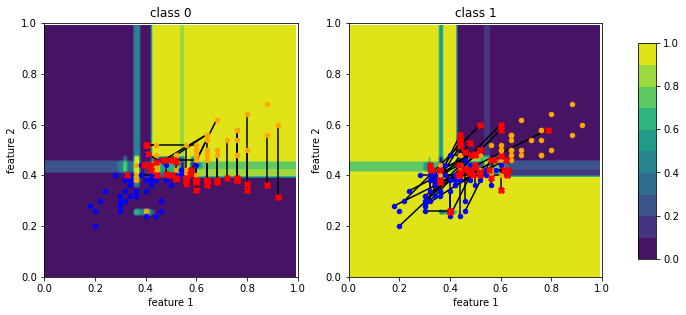

In [20]:
num_classes = 2
x_train, y_train = get_data(num_classes=num_classes)
x_train_adv, model = get_adversarial_examples(x_train, y_train)
plot_results(model, x_train, y_train, x_train_adv, num_classes)

ZOO: 100%|███████████████████████████████████████████████████████████████████████████| 150/150 [00:17<00:00,  8.67it/s]


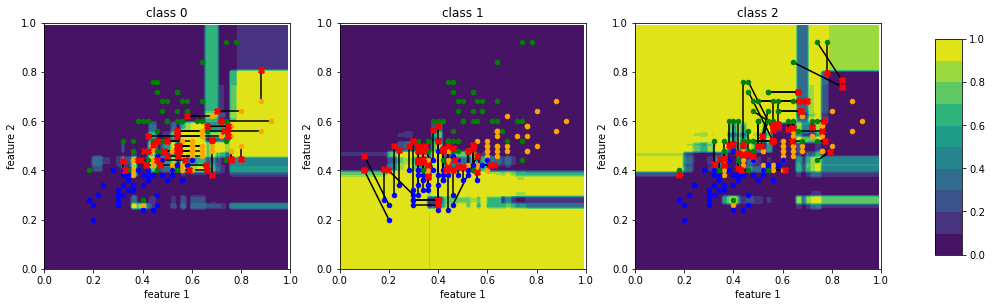

In [16]:
# num_classes = 3
# x_train, y_train = get_data(num_classes=num_classes)
# x_train_adv, model = get_adversarial_examples(x_train, y_train)
# plot_results(model, x_train, y_train, x_train_adv, num_classes)

# 3 Example: MNIST

## 3.1 Load and transform MNIST dataset

In [12]:
# (x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

# n_samples_train = x_train.shape[0]
# n_features_train = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]
# n_samples_test = x_test.shape[0]
# n_features_test = x_test.shape[1] * x_test.shape[2] * x_test.shape[3]

# x_train = x_train.reshape(n_samples_train, n_features_train)
# x_test = x_test.reshape(n_samples_test, n_features_test)

# y_train = np.argmax(y_train, axis=1)
# # y_test = np.argmax(y_test, axis=1)

# n_samples_max = 200
# x_train = x_train[0:n_samples_max]
# y_train = y_train[0:n_samples_max]
# x_test = x_test[0:n_samples_max]
# y_test = y_test[0:n_samples_max]

## 3.2 Train GradientBoostingClassifier classifier

In [21]:
model = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, 
                                   criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, 
                                   min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, 
                                   min_impurity_split=None, init=None, random_state=None, max_features=None, 
                                   verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto', 
                                   validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)

In [22]:
model.fit(X=x_train, y=y_train)

GradientBoostingClassifier(presort='auto')

## 3.3 Create and apply Zeroth Order Optimization Attack with ART

In [23]:
art_classifier = SklearnClassifier(model=model)

In [24]:
zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=100,
                binary_search_steps=20, initial_const=1e-3, abort_early=True, use_resize=False, 
                use_importance=False, nb_parallel=10, batch_size=1, variable_h=0.25)

In [25]:
x_train_adv = zoo.generate(x_train)

ZOO:   0%|                                                                                     | 0/100 [00:00<?, ?it/s]


ValueError: Cannot take a larger sample than population when 'replace=False'

In [23]:
x_test_adv = zoo.generate(x_test)

ZOO: 100%|███████████████████████████████████████████████████████████████████████████| 200/200 [08:00<00:00,  2.40s/it]


## 3.4 Evaluate GradientBoostingClassifier on benign and adversarial samples

In [26]:
score = model.score(x_train, y_train)
print("Benign Training Score: %.4f" % score)

Benign Training Score: 0.9600


In [27]:
# plt.matshow(x_train[0, :].reshape((28, 28)))
# plt.clim(0, 1)

ValueError: cannot reshape array of size 2 into shape (28,28)

In [28]:
prediction = model.predict(x_train[0:1, :])[0]
print("Benign Training Predicted Label: %i" % prediction)

Benign Training Predicted Label: 0


In [29]:
score = model.score(x_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

Adversarial Training Score: 0.0900


In [31]:
prediction = model.predict(x_train_adv[0:1, :])[0]
print("Adversarial Training Predicted Label: %i" % prediction)

Adversarial Training Predicted Label: 1


In [32]:
score = model.score(x_test, y_test)
print("Benign Test Score: %.4f" % score)

ValueError: Number of features of the model must match the input. Model n_features is 2 and input n_features is 13 

In [38]:
x_test[0:1, :]

array([[5.100e+01, 1.000e+01, 0.000e+00, 3.500e+01, 2.200e+01, 1.100e+01,
        4.677e+03, 4.100e+01, 3.300e+01, 1.431e+04, 5.093e+03, 4.100e+01,
        6.000e+00]])

In [34]:
prediction = model.predict(x_test[0:1, :])[0]
print("Benign Test Predicted Label: %i" % prediction)

ValueError: Number of features of the model must match the input. Model n_features is 2 and input n_features is 13 

In [35]:
score = model.score(x_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

NameError: name 'x_test_adv' is not defined

In [36]:
plt.matshow(x_test_adv[0, :].reshape((28, 28)))
plt.clim(0, 1)

NameError: name 'x_test_adv' is not defined

In [37]:
prediction = model.predict(x_test_adv[0:1, :])[0]
print("Adversarial Test Predicted Label: %i" % prediction)

NameError: name 'x_test_adv' is not defined